# Imports and definitions

In [1]:
from utils import *

#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MuseoEgizio2022/MappaKhaMerit/'

path_xrd = path_scan + 'XRD/Acquisition0001/'     # XRD scan
path_zmap = path_shared + 'VenereBZPosition/'

path_xrf_images= path_scan + 'XRF/IMAGES/'     # XRF scan
path_xrf_spectra = path_scan + 'XRF/IMAGES/'   # XRF scan

path_photo = path_scan + 'VIS/'       # photo of the scanned section

#path_database = path_shared + 'Database/'     # tabulated phases
path_database = path_shared + 'DatabaseEXP/'     # tabulated phases ### QUELLO GIUSTO PER MUSEO EGIZIO

### Output ###
subfolder_output = 'output/'
path_figures = subfolder_output + 'figures/'          # figures generated by the script
path_results = subfolder_output + 'results/'          # results generated by the script: raw data, tif maps
path_database_exp = subfolder_output + 'databaseEXP/' # experimental phases
path_calibrations = subfolder_output + 'calibrations/'  # calibrated XRD spectra

### Parameters ###
min_theta = 17
max_theta = 42
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = 5    # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.15         # sigma used in the peaks of synthetic diffraction patterns

### Reading XRF ###
xrf_axes_flip = [1] # which axes to flip when reading XRF data (0: vertical, 1: horizontal)


paths_to_create_delete = [path_figures, path_results]


### Rotating the image clockwise at reading time: number of steps of 90 degrees ###
steps_rotation_xrd = 0
steps_rotation_xrf = 2

# Read phase database

In [2]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:', len(database))

Phases in database: 33


# Read XRD data
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print('\nShape of data\n-------------')
print(f'x: {data.shape[1]}, y: {data.shape[0]}, channels: {data.shape[2]}')
print('\nInitial calibration\n-------------------')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range: {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

Loading: ../../shared/dataXRDXRF/MuseoEgizio2022/MappaKhaMerit/XRD/Acquisition0001/xrd.h5

Shape of data
-------------
x: 114, y: 100, channels: 1280

Initial calibration
-------------------
a = -1233.1, s = 2770.7, beta = 41.190
Theta range: [17.19831368984754, 42.15992736671881]


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [4]:
qtl = 0.999

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

12 pixels out of 11400 were corrected.


### Smoothing along channels and background elimination

In [5]:
offset_background = 10  # value added to the background, before subtracting it from the raw signal
std_smooth = 1          # degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

data.background_elimination_and_smoothing(offset_background = offset_background, std_smooth = std_smooth, avoid_negative = True)

Removing background and smoothing along channels...
Done.


# Select primary phases

### Manually select them

In [6]:
P1 = database['Huntite'][0]
P2 = database['Orpiment'][0]
P3 = database['Manganite'][0]
P4 = database['Cuprorivaite'][0]

phases_primary = [P1, P2, P3, P4]
#phases_primary = [P2, P3, P4]

In [7]:
P1.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

(array([31.56293807]), array([1.]))

# Analyse problematic pixel

In [8]:
x, y = 82, 18
p = 0

In [9]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gs = gm.get_pixel(x, y)

In [11]:
gs.fit_cycle(steps = 4, gamma = True, downsample = 3)
gs.fit_cycle(steps = 1, a = True, s = True, gamma = True, downsample = 2)

gs.select(None)
gs.set_opt(gs.selected.opt, copy = False)

gs.selected.fit_cycle(steps = 2, a = True, s = True, gamma = True, downsample = 3)
gs.selected.fit_cycle(steps = 2, a = True, s = True, gamma = True, downsample = 2)
gs.selected.fit_cycle(steps = 2, a = True, s = True, gamma = True, downsample = 0)

gs.fit_cycle(steps = 1, gamma = True, downsample = 3)
gs.fit_cycle(steps = 1, gamma = True, downsample = 2)
gs.fit_cycle(steps = 2, gamma = True, downsample = 0)

None

/Users/dariozappala/.local/lib/python3.8/site-packages/XRDXRFutils/gaussnewton.py:61: RuntimeWarning: overflow encountered in square
  return 0.5 * (sqrt(x**2 + 1) + x)
/Users/dariozappala/.local/lib/python3.8/site-packages/XRDXRFutils/gaussnewton.py:164: RuntimeWarning: invalid value encountered in multiply
  self.component_full = I * self.gamma * self.component_core
/Users/dariozappala/.local/lib/python3.8/site-packages/XRDXRFutils/gaussnewton.py:65: RuntimeWarning: overflow encountered in square
  return 0.5 * (x / sqrt(x**2 + 1) + 1)


In [50]:
gs.idx

3

In [140]:
gs.fit_cycle(steps = 1, gamma = True, downsample = 3)

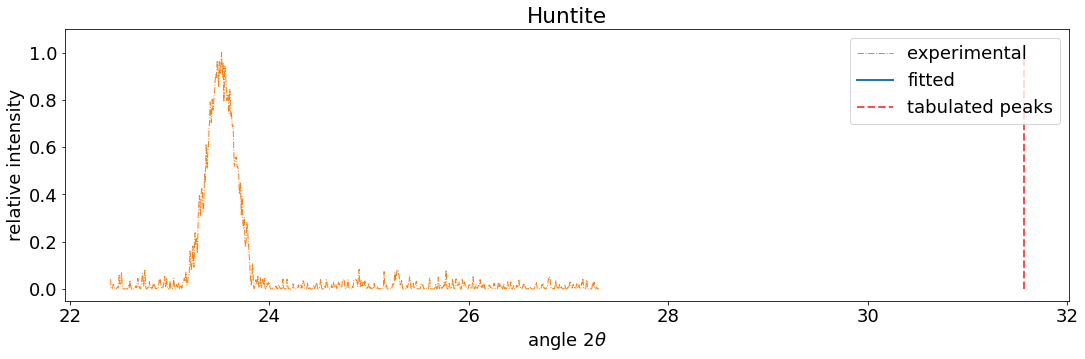

Overlap area: nan
Overlap area ratio: nan
a = -4677.1, s = 13754.9, beta = 41.190
g: [[nan]]
gamma: [[nan]]
Tabulated angle: 31.563


In [12]:
gn = gs[p]
gn = gn.downsample(0)

rcParams['font.size'] = 18

fig, ax = subplots(figsize = (18, 5))
sca(ax)
gn.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
gn.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
gn.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks', min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)
#ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1.1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}')
ax.legend(loc = 'upper right')
show()

print(f'Overlap area: {gn.overlap_area():.3f}')
print(f'Overlap area ratio: {gn.overlap_area_ratio():.3f}')
print(f'a = {gn.opt[0]:.1f}, s = {gn.opt[1]:.1f}, beta = {gn.opt[2]:.3f}')
print(f'g: {gn.g}')
print(f'gamma: {gn.gamma}')
angle_tabulated = gn.phase.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)[0][0]
print(f'Tabulated angle: {angle_tabulated:.3f}')

In [102]:
width_checked = 3
gn.theta[(gn.theta >= angle_tabulated - width_checked * sigma) & (gn.theta <= angle_tabulated + width_checked * sigma)]

array([], dtype=float64)

In [108]:
mu = gn.mu[newaxis, :]
mu

array([[31.56293807]])

In [148]:
tr_min, tr_max = gn.theta_range()
mu[(mu > tr_min) & (mu < tr_max)]

array([], dtype=float64)

In [109]:
I = gn.I[newaxis, :]
I

array([[1.]])

In [110]:
theta = gn.theta[:, newaxis]
theta

array([[22.39911028],
       [22.40288605],
       [22.40666199],
       ...,
       [27.35041701],
       [27.35438881],
       [27.35836076]])

In [111]:
gn.sigma2

array([[0.0225]])

In [117]:
gn.gamma

array([[nan]])

In [115]:
from numpy import exp
component_core = exp((theta - mu)**2 / (-2 * gn.sigma2))
component_core

array([[0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       ...,
       [5.49526268e-172],
       [1.15553732e-171],
       [2.42820871e-171]])

In [118]:
component_full = I * gn.gamma * component_core

In [31]:
gn.downsample_level

0

# Search for problematic pixels

In [23]:
%%time

gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gm = gm.search()

Using 8 CPUs
CPU times: user 7 s, sys: 1.27 s, total: 8.28 s
Wall time: 10.8 s


In [24]:
provola = gm.z()
provola.shape

(100, 114, 4, 1280)

In [25]:
isnan(provola).sum()

0

In [26]:
provola.size

58368000

In [15]:
indices = argwhere(isnan(provola))

In [16]:
indices.shape

(24320, 4)

In [17]:
indices[0]

array([ 4, 37,  1,  0])

In [18]:
y, x = 4, 37
p = 0